# Introduction

In this worksheet we are going to compare an analytical version of an SI model (Susceptible-Infected, a very simple epidemiological model) with an agent-based solution. This will show why it is in some situations necessary to use agent-based models while at the same time demonstrating the implementation details.

# An analytical SI model

The SI (susceptible-infected) model is a simple epidemiological model with a [long tradition](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). It is based on the assumption that the modelled population is large and homogeneous enough for stochasticity, individual differences and waiting times between events to become irrelevant. This makes it possible to treat the healthy and infected portions of the population as "compartments" with infections and recoveries as "flows" between them which can be modelled using some [very well understood mathematics](https://en.wikipedia.org/wiki/Multi-compartment_model).

We implement the model using the [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl) package. We start by defining the update function.

In [6]:
# we need this for the solution
using DifferentialEquations

# f updates the derivative du dependent on the 
# current state u using parameters p 
# TODO what about t?
function f(du, u, p, t) 
    # parameters
    β, γ = p
    # susceptible
    du[1] = -β * u[2]*u[1] +   # infection
             γ * u[2]          # recovery
    # infected
    du[2] = β * u[2]*u[1] -    # infection
            γ * u[2]           # recovery
end

f (generic function with 1 method)

To numerically solve the system we have to define boundary conditions and parameter values.

In [2]:
p = (0.1, 0.03)       # parameters beta, gamma
u0 = [0.99, 0.001]    # initial conditions
tspan = (1.0, 500.0)  # simulation time
# prepare the problem
problem = ODEProblem(f, u0, tspan, p)
# and solve it
deqsolution = solve(problem);

DifferentialEquations provides some infrastructure to make plotting a solution (using the Plots package) very straightforward.

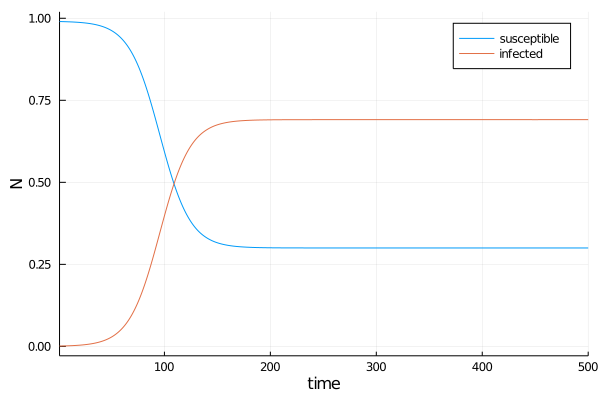

In [3]:
using Plots; gr() # Using the Plotly Backend
Plots.plot(deqsolution, xlabel="time", ylabel="N", lab=["susceptible" "infected"])

If we want to try different parameter values we have to solve again.

In [5]:
p = (0.1, 0.06)       # parameters beta, gamma
u0 = [0.99, 0.001]    # initial conditions
tspan = (1.0, 500.0)  # simulation time
# prepare the problem
problem = ODEProblem(f, u0, tspan, p);
# and solve it
deqsolution = solve(problem);

We can compare the two solutions by plotting them in the same graph. We do this by simply calling `plot!` instead of `plot` (by convention the '!' indicates that a function modifies its arguments, in this case the previous graph).

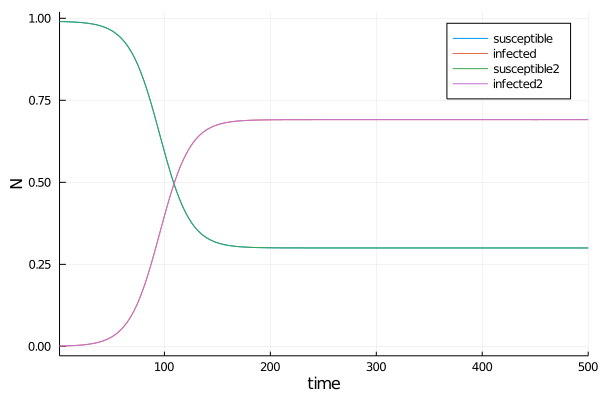

In [4]:
Plots.plot!(deqsolution, xlabel="time", ylabel="N", lab=["susceptible2" "infected2"])

# An agent-based version

We are now going to implement an agent-based version of the same model. We will start off with a very simplistic implementation that is as close to the analytical model as possible and then add complications that will clarify the advantages of using an ABM.

## Prelude

Some modules we are going to need down the line.

In [1]:
using Random

## Type declarations

Now we need to tell Julia about how the objects look like that we are going to use. 

An `@enum` is a type that can only have a handful of named values, e.g.:
```Julia
@enum WeekDay Monday Tuesday Wednesday Thursday Friday
```

In [2]:
# all possible states a person can be in
@enum Status susceptible infected

# this is our agent type
mutable struct SimplePerson
    # state
    belief :: Float64
    know :: Bool
    # other agents this one can infect or be infected by
    contacts :: Vector{SimplePerson}
end

# how we construct a person object
SimplePerson(belief, know) = SimplePerson(belief, know, [])
#SimplePerson() = SimplePerson(susceptible, [])   # default Person is susceptible and has no contacts
#SimplePerson(state) = SimplePerson(state, [])  # default Person has no contacts

SimplePerson

The simulation itself is mainly used for bookkeeping. We might want to switch out the Agent type later, therefore we keep it as a parameter to the Simulation type (using a so-called [parametric type](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types)).

In [3]:
# this is a parametric type
# we can specify which type AGENT is going to be replaced with
# when constructing our Simulation
mutable struct Simulation{AGENT}
    # model parameters:
    # infection rate
    #inf :: Float64
    # recovery rate
    #rec :: Float64
    p :: Float64

    # and this is our population of agents
    pop :: Vector{AGENT}
end

## The model

First we implement the update functions that change the agents' state. In this version of the model we use simple updating in time steps.

Note that none of these include type information and can therefore be used for any agent type with the right struct members.

In [8]:
# update function for susceptible individuals
function update_susceptible!(person, sim)
    if length(person.contacts) == 0
        return
    end
    # if random contact is infected check for transmission
    if rand(person.contacts).status == infected && rand() < sim.inf
        person.status = infected
    end
end

# update function for infected individuals
function update_infected!(person, sim)
    if rand() < sim.rec
        person.status = susceptible
    end
end

# update an agent
function update!(person, sim)
    if person.know && rand() < sim.p
        other = rand(person.contacts)
        if other.know
            other.belief = (person.belief + other.belief) * 0.5
        else
            other.know = true
            other.belief = person.belief * 0.9 
        end
        
    end
end

update! (generic function with 1 method)

We now have to call these functions for every agent in our simulation at every time step.

In [5]:
function update_agents!(sim)
    # we need to change the order, otherwise agents at the beginning of the 
    # pop array will behave differently from those further in the back
    order = shuffle(sim.pop)
    
    for p in order
        update!(p, sim)
    end
end   

update_agents! (generic function with 1 method)

## Running the model

With that out of the way we can create the simulation and run it. The only thing left to do is to setup our population. 

Note that if we *only* wanted to do a fully mixed population there would be no need to explicitly track contacts per agent and to set up the population like this. However, we might also look at situations where agents know only part of the population therefore we do it this way.

In [6]:
# set up a mixed population
# p_contact is the probability that two agents are connected
function setup_mixed(n, p_contact)
    pop = [ SimplePerson(rand(), false) for i=1:n ]

    # go through all combinations of agents and 
    # check if they are connected
    for i in eachindex(pop)
        for j in i+1:length(pop)
            if rand() < p_contact
                push!(pop[i].contacts, pop[j])
                push!(pop[j].contacts, pop[i])
            end
        end
    end

    pop
end

setup_mixed (generic function with 1 method)

At this point we can already run the simulation.

<span style='color:Red'>See if you can complete the code below on your own. You should be able to produce a spreading infection.</span>

In [9]:
# TODO add arguments
pop = setup_mixed(1000, 1.0) 

pop[1].know = true
pop[2].know = true
pop[3].know = true

# is there anything else we need to do here?

# TODO add arguments
sim = Simulation(1.0, pop)

for i in 1:20
    update_agents!(sim)
    
    println(count(p -> p.know == true, sim.pop)) # prints current number of infected
end

6
14
39
105
233
433
708
875
949
977
991
994
998
1000
1000
1000
1000
1000
1000
1000


---

To make things a bit easier down the line I have wrapped both, the setup and the model run into their own separate functions.

In [28]:
#                     function parameters after ; have to be 
#                     named on call 
function  setup_sim(;p, N, p_c, n_inf, b, seed)
    # for reproducibility
    Random.seed!(seed)

    # create a population of agents, fully mixed
    pop = setup_mixed(N, p_c)

    # create a simulation object with parameter values
    sim = Simulation(p, pop)
    for i in 1:n_inf
        # one percent of agents are infected
        sim.pop[i].know = true
        sim.pop[i].belief = b
    end
    
    sim
end

setup_sim (generic function with 1 method)

In [21]:
function run_sim(sim, n_steps, verbose = false)
    # we keep track of the numbers
    knowing = Int[]
    avg_belief = Float64[]
    
    n = length(sim.pop)

    # simulation steps
    for t in  1:n_steps
        update_agents!(sim)
        
        push!(knowing, count(p -> p.know == true, sim.pop))
        
        avg = 0
        for i in 1:n
            if sim.pop[i].know
                avg = avg + sim.pop[i].belief
            end
        end
        n_know = count(p -> p.know == true, sim.pop)
        push!(avg_belief, avg /n_know)
        
        # a bit of output
        #if verbose
        #    println(t, ", ", n_inf[end], ", ", n_susc[end])
        #end
    end
    
    # return the results (normalized by pop size)
    knowing./n, avg_belief
end

run_sim (generic function with 2 methods)

With that in place running the model and displaying the result is quite easy.

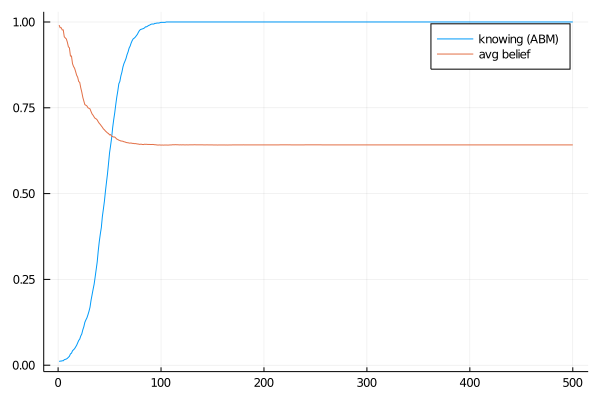

In [29]:
using Plots; gr() # Using the Plotly Backend

sim = setup_sim(p=0.1, N=1000, p_c=1.0, n_inf=10, b=1.0, seed=42)
# inf and susc are arrays containing the proportion of infected/susceptible over time
knowing, avg_belief = run_sim(sim, 500)

Plots.plot([knowing, avg_belief], labels = ["knowing (ABM)" "avg belief"])

## Comparison with analytical model

We are now ready to compare the ABM and the analytical model. 

<span style='color:Red'> Let's run the model using the same parameter values as we used for the analytical version and plot both in the same graph.</span>

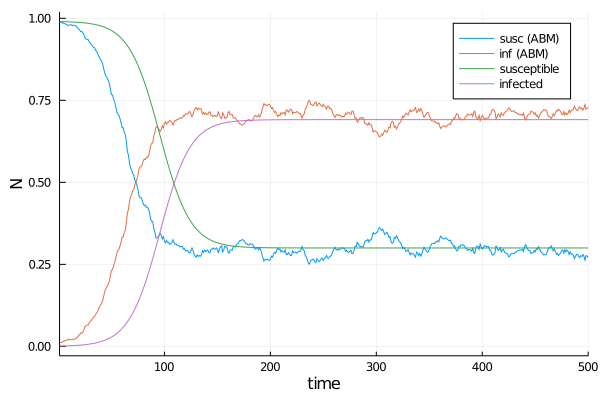

In [39]:
# TODO add code to run the ABM with the same parameters as the diff eq and plot it
# code goes here


p = (0.1, 0.03)       # parameters beta, gamma
u0 = [0.99, 0.001]    # initial conditions
tspan = (1.0, 500.0)  # simulation time
problem = ODEProblem(f, u0, tspan, p)
deqsolution = solve(problem);

Plots.plot!(deqsolution, xlabel="time", ylabel="N", lab=["susceptible" "infected"])

 <span style='color:Red'> Can you think of a reason for the difference in results?
 </span>

# Adding space

The analytical as well as the first agent-based version of the model assumed that our population is well-mixed, i.e. that any two individuals/agents meet with the same probability. This is obviously unrealistic as soon as we go beyond the level of a single social group. Does it matter, though?

Let's implement a very simple spatial version of the model and see if we get different results.

In [40]:
# this is our agent type
# in principle we could have re-used the Person type from before, however,
# it is much easier to produce a nice visualization of the model if we
# keep the coordinates in the agents (as we will se below)
mutable struct SpacePerson
    # state
    status :: Status
    # other agents this one can infect or be infected by
    contacts :: Vector{SpacePerson}
    # location in the world
    x :: Float64
    y :: Float64
end

# how we construct a person object
SpacePerson(x, y) = SpacePerson(susceptible, [], x, y)   # default Person is susceptible and has no contacts
SpacePerson(state, x, y) = SpacePerson(state, [], x, y)  # default Person has no contacts

SpacePerson

We kept the agent type as a parameter to the Simulation type therefore we don't need to change it.

## The model

Since our update functions (see above) didn't contain any type information we actually don't have to do anything here (yay generic programming!).

## Running the model

The spatial setup is a tad fiddly, therefore I put it in a separate file (take a look if you are interested) and include it here.

In [41]:
include("setup_world.jl");

This sets up the simulation and the agents.

In [42]:
function setup_space_sim(; p_i, p_r, xs, ys, n_inf, seed)
    # create a population of agents living on a 
    # 50x50 grid (von Neumann)
    pop = setup_grid(SpacePerson, xs, ys)
    
    # create a simulation object with parameter values
    sim = Simulation(p_i, p_r, pop)

    # for reproducibility
    Random.seed!(seed)

    # pick n_inf random agents and set them to infected
    for p in rand(sim.pop, n_inf)
        p.status = infected
    end
    
    sim
end

setup_space_sim (generic function with 1 method)

The run function hasn't changed either, so we are done with the preliminaries and can proceed with running the simulation and plotting it against the simple, non-spatial version. 

This time we have to specify the size of the world (as `xs` and `ys`) instead of the number of agents, otherwise the function calls are identical. As before we try to keep the parameters as close to the analytical version as possible.

<span style='color:Red'> Try to run the spatial model using the same parameters as the simple version. Plot the results of both in the same graph to make them easier to compare. </span>

In [ ]:
# TODO run spatial model here

# Plots.plot([susc, inf], labels = ["susc" "inf"])

# TODO run simple model here

# Plots.plot!([susc, inf], labels = ["susc (mixed)" "inf (mixed)"])

But wait a moment. In the spatial model we drastically reduced the number of contacts per agent, didn't we? What happens if we do the same in the simple model?

<span style='color:Red'> Re-run the simple model with reduced numbers of contacts and plot the results. </span>

In [ ]:
# TODO run low-contact version of the simple model here

# Plots.plot!([susc, inf], labels = ["susc (low contacts)" "inf (low contacts)"])

## Visualisation

It is generally a good idea to have a proper visualisation for a simulation. It makes it a lot easier to catch bugs, over time it provides an intuition of the system's behaviour and it is fun.

Usually it would be good to have a dynamic display of the system state over time, but for this simple example we will make do with static output. If you want to track the progress of the simulation you can just execute `runsim(sim, 500)` again and then rerun the visualisation.

In [43]:
# this uses the Luxor package, which allows for very straighforward 
# generation of SVG (PDF, etc.) drawings
using Luxor

sim = setup_space_sim(p_i=0.1, p_r=0.03, xs=50, ys=50, n_inf=10, seed=42)
inf, susc = run_sim(sim, 50)

@svg begin
    # scale from model coordinates to screen coordinates
    f_scale = 11
    # size of agents
    p_size = 5
    
    # otherwise we'll only have to lower right quarter
    # (don't ask...)
    origin(0, 0)

    # paint it black
    sethue("black")
    
    # ** first draw all connections
    # (we don't want to worry about agent size here,
    #  so we just draw the lines from x1,y1 to x2,y2
    #  and paint the agents on top of that)
    
    # for each agent
    for p in sim.pop
        x1 = p.x * f_scale
        y1 = p.y * f_scale
        
        # draw all lines to other agents
        for p2 in p.contacts
            x2 = p2.x * f_scale
            y2 = p2.y * f_scale
            
            setline(1)
            setdash("solid")
            line(Point(x1, y1), Point(x2, y2), :stroke)
        end
    end
    # yes, this draws all lines twice
    # who cares

    # ** now draw all agents
    
    for p in sim.pop
        x = p.x * f_scale
        y = p.y * f_scale
        
        # show the status as colours
        if p.status == infected
            sethue("red")
        elseif p.status == susceptible
            sethue("blue")
        end
        
        circle(Point(x, y), p_size, :fill)
    end
end

┌ Info: Precompiling Luxor [ae8d54c2-7ccd-5906-9d76-62fc9837b5bc]
└ @ Base loading.jl:1278


# Things to try

* Run for longer, is there an equilibrium or an end state?
* Try different values for `inf` and `rec`.
* Does changing the shape of the world (`x` vs. `y` size) have an effect?